In [1]:
!pip3 install --upgrade decorator
!pip3 install --upgrade networkx

![sas](../Documentation/UserJourneyGraph.png)

### Graphs over different `event_type`: View, Cart, Purchase
We can construct graph with any of the event_type. 
* Co-occurence graph over PDP Views, in one session sequence of PDPs viewed together by a user
* Co-occurence graph over products that are Add to Cart together
* Co-occurence graph over products that are bought together

With every graph constructed over different event_type one will have different representation of an product. 

For our problem we wanted to build a recommendation system such that product recommeneded is similar or relevant to the product user is currently viewing. (Samsung TV example discussed earlier)

In [2]:
import pandas as pd
import numpy as np
import duckdb
import time
import networkx as nx
import matplotlib.pyplot as plt

start = time.time()
con = duckdb.connect(database=':memory:', read_only=False)

### Query for Session with more than 1 pdp view

In [25]:
con.query('''
SELECT 
user_session, 
count(distinct product_id) as count_pdp_views_per_session
FROM '../Data/optimised_raw_data.parquet'
WHERE event_type = 'view'
  AND user_session IS NOT NULL
  AND product_id IS NOT NULL
GROUP BY user_session
HAVING count(distinct product_id) > 1
''').df()

user_session  count_pdp_views_per_session
0        69b5d72f-fd6e-4fed-aa23-1286b2ca89a0                            8
1        7f596032-ccbf-4643-9bad-e36a209512b4                            4
2        31b7d4cf-dfac-4895-9927-90fa3254f860                            2
3        c161400e-630b-4b59-8797-d9b9714444bf                            2
4        44ca9bc7-3ba8-4546-bdf5-10b2172ed883                            2
...                                       ...                          ...
5340110  3df590c0-e667-4f5a-aa87-f47749cd6408                            2
5340111  e1252736-1d34-40c5-8aab-af2e5bff3201                            2
5340112  21f46782-fb36-4d5c-82d4-6dc26ae93fad                            2
5340113  4d614d05-3b0c-4504-a75e-9e09715f737f                            3
5340114  f467f7ab-6709-4836-80ba-0d1bd8d1a267                            3

[5340115 rows x 2 columns]

#### There are 7Million+ sessions with more than 1 pdp view and 5M+ are distinct product views

In [4]:
con.execute('''
CREATE TABLE product_view_tbl AS
SELECT 
user_id,
product_id, 
CAST(event_time[:-3] as DATETIME) as event_time, 
user_session
FROM '../Data/optimised_raw_data.parquet'
WHERE user_session in (SELECT 
user_session
FROM '../Data/optimised_raw_data.parquet'
WHERE event_type = 'view'
  AND user_session IS NOT NULL
  AND product_id IS NOT NULL
GROUP BY user_session
HAVING count(distinct product_id) > 1)
ORDER BY user_session, CAST(event_time[:-3] as DATETIME)
''').df()

Count
0  43408767

In [6]:
con.query("""SELECT *
FROM product_view_tbl
WHERE user_session = '29e0ff8c-d2c0-474b-b02b-8a17445100c8'""").df()

user_id  product_id          event_time  \
0   519798087    26201121 2020-01-01 00:00:11   
1   519798087    26204318 2020-01-01 00:00:42   
2   519798087    26200951 2020-01-01 00:01:14   
3   519798087    26200951 2020-01-01 00:01:27   
4   519798087    26203272 2020-01-01 00:01:46   
5   519798087    26203272 2020-01-01 00:02:01   
6   519798087    26201124 2020-01-01 00:02:29   
7   519798087    26201124 2020-01-01 00:02:35   
8   519798087    26200344 2020-01-01 00:03:27   
9   519798087   100037882 2020-01-01 00:04:04   
10  519798087   100037882 2020-01-01 00:04:24   
11  519798087    26204653 2020-01-01 00:05:14   
12  519798087    26202732 2020-01-01 00:06:30   
13  519798087   100000092 2020-01-01 00:06:51   

                            user_session  
0   29e0ff8c-d2c0-474b-b02b-8a17445100c8  
1   29e0ff8c-d2c0-474b-b02b-8a17445100c8  
2   29e0ff8c-d2c0-474b-b02b-8a17445100c8  
3   29e0ff8c-d2c0-474b-b02b-8a17445100c8  
4   29e0ff8c-d2c0-474b-b02b-8a17445100c8  
5   29e0ff8c-d2c0-474b-b02b-8a17445100c8  
6   29e0ff8c-d2c0-474b-b02b-8a17445100c8  
7   29e0ff8c-d2c0-474b-b02b-8a17445100c8  
8   29e0ff8c-d2c0-474b-b02b-8a17445100c8  
9   29e0ff8c-d2c0-474b-b02b-8a17445100c8  
10  29e0ff8c-d2c0-474b-b02b-8a17445100c8  
11  29e0ff8c-d2c0-474b-b02b-8a17445100c8  
12  29e0ff8c-d2c0-474b-b02b-8a17445100c8  
13  29e0ff8c-d2c0-474b-b02b-8a17445100c8

In [30]:
sub_graph = con.query("""SELECT 
       product_id,
       LEAD(product_id, 1, -1) OVER (PARTITION BY user_session ORDER BY event_time) AS next_viewed_product_id,
        user_session,
        event_time
FROM product_view_tbl
WHERE user_session = '29e0ff8c-d2c0-474b-b02b-8a17445100c8' """).df()
sub_graph

product_id  next_viewed_product_id                          user_session  \
0     26201121                26204318  29e0ff8c-d2c0-474b-b02b-8a17445100c8   
1     26204318                26200951  29e0ff8c-d2c0-474b-b02b-8a17445100c8   
2     26200951                26200951  29e0ff8c-d2c0-474b-b02b-8a17445100c8   
3     26200951                26203272  29e0ff8c-d2c0-474b-b02b-8a17445100c8   
4     26203272                26203272  29e0ff8c-d2c0-474b-b02b-8a17445100c8   
5     26203272                26201124  29e0ff8c-d2c0-474b-b02b-8a17445100c8   
6     26201124                26201124  29e0ff8c-d2c0-474b-b02b-8a17445100c8   
7     26201124                26200344  29e0ff8c-d2c0-474b-b02b-8a17445100c8   
8     26200344               100037882  29e0ff8c-d2c0-474b-b02b-8a17445100c8   
9    100037882               100037882  29e0ff8c-d2c0-474b-b02b-8a17445100c8   
10   100037882                26204653  29e0ff8c-d2c0-474b-b02b-8a17445100c8   
11    26204653                26202732  29e0ff8c-d2c0-474b-b02b-8a17445100c8   
12    26202732               100000092  29e0ff8c-d2c0-474b-b02b-8a17445100c8   
13   100000092                      -1  29e0ff8c-d2c0-474b-b02b-8a17445100c8   

            event_time  
0  2020-01-01 00:00:11  
1  2020-01-01 00:00:42  
2  2020-01-01 00:01:14  
3  2020-01-01 00:01:27  
4  2020-01-01 00:01:46  
5  2020-01-01 00:02:01  
6  2020-01-01 00:02:29  
7  2020-01-01 00:02:35  
8  2020-01-01 00:03:27  
9  2020-01-01 00:04:04  
10 2020-01-01 00:04:24  
11 2020-01-01 00:05:14  
12 2020-01-01 00:06:30  
13 2020-01-01 00:06:51

In [8]:
edge_list = [[x[0], x[1]] for x in sub_graph[['product_id', 'next_viewed_product_id']].to_numpy()]
edge_list

[[26201121, 26204318],
 [26204318, 26200951],
 [26200951, 26200951],
 [26200951, 26203272],
 [26203272, 26203272],
 [26203272, 26201124],
 [26201124, 26201124],
 [26201124, 26200344],
 [26200344, 100037882],
 [100037882, 100037882],
 [100037882, 26204653],
 [26204653, 26202732],
 [26202732, 100000092],
 [100000092, -1]]

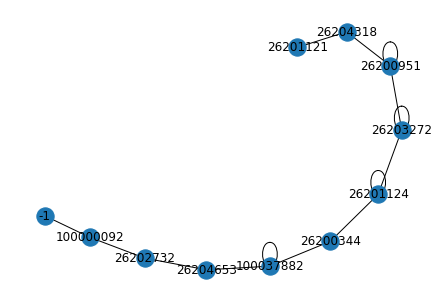

In [9]:
G = nx.Graph()
G.add_edges_from(edge_list)
nx.draw(G, with_labels=True)
plt.show()

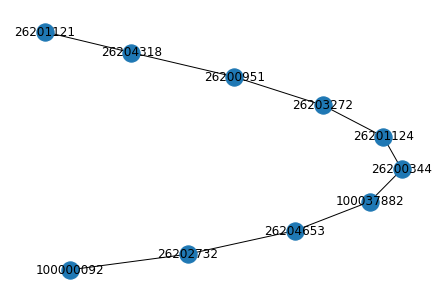

In [10]:
sub_graph = con.query("""
SELECT * FROM (SELECT 
       product_id,
       LEAD(product_id, 1, -1) OVER (PARTITION BY user_session ORDER BY event_time) AS next_viewed_product_id,
        user_session,
        event_time
FROM product_view_tbl
WHERE user_session = '29e0ff8c-d2c0-474b-b02b-8a17445100c8' ) as A where product_id<>next_viewed_product_id and next_viewed_product_id<>-1""").df()
edge_list = [[x[0], x[1]] for x in sub_graph[['product_id', 'next_viewed_product_id']].to_numpy()]
G = nx.Graph()
G.add_edges_from(edge_list)
nx.draw(G, with_labels=True)
plt.show()

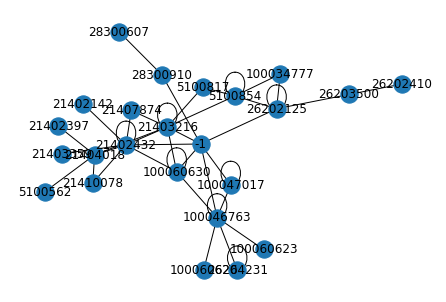

In [11]:
sub_graph = con.query("""SELECT 
       product_id,
       LEAD(product_id, 1, -1) OVER (PARTITION BY user_session ORDER BY event_time) AS next_viewed_product_id,
        user_session,
        event_time
FROM product_view_tbl
WHERE user_id = '518269232'""").df()

edge_list = [[x[0], x[1]] for x in sub_graph[['product_id', 'next_viewed_product_id']].to_numpy()]
G = nx.Graph()
G.add_edges_from(edge_list)

nx.draw(G, with_labels=True)
plt.show()


In [12]:
%%time
con.execute("""CREATE TABLE product_views_graph AS select product_id, 
LEAD(product_id, 1, -1) OVER (PARTITION BY user_session ORDER BY event_time) as next_viewed_product_id,
user_session,
event_time
from product_view_tbl
""").df()

CPU times: user 6min 11s, sys: 1min 3s, total: 7min 15s
Wall time: 43.1 s


Count
0  43408767

In [13]:
con.query("""SELECT * FROM product_views_graph LIMIT 15""").df()

product_id  next_viewed_product_id                          user_session  \
0      5000427                 5000583  000fe336-1fc8-446e-bb12-e7f8bd0c9c58   
1      5000583                 5000427  000fe336-1fc8-446e-bb12-e7f8bd0c9c58   
2      5000427                 5000427  000fe336-1fc8-446e-bb12-e7f8bd0c9c58   
3      5000427                26021255  000fe336-1fc8-446e-bb12-e7f8bd0c9c58   
4     26021255                26016163  000fe336-1fc8-446e-bb12-e7f8bd0c9c58   
5     26016163                26016163  000fe336-1fc8-446e-bb12-e7f8bd0c9c58   
6     26016163                26016163  000fe336-1fc8-446e-bb12-e7f8bd0c9c58   
7     26016163                26000276  000fe336-1fc8-446e-bb12-e7f8bd0c9c58   
8     26000276                26026427  000fe336-1fc8-446e-bb12-e7f8bd0c9c58   
9     26026427               100074135  000fe336-1fc8-446e-bb12-e7f8bd0c9c58   
10   100074135                26026427  000fe336-1fc8-446e-bb12-e7f8bd0c9c58   
11    26026427                      -1  000fe336-1fc8-446e-bb12-e7f8bd0c9c58   
12     3700926                 3701387  001f327e-1dc7-40dc-868d-3b648905f845   
13     3701387                 3700781  001f327e-1dc7-40dc-868d-3b648905f845   
14     3700781               100017448  001f327e-1dc7-40dc-868d-3b648905f845   

            event_time  
0  2020-01-17 05:14:35  
1  2020-01-17 05:15:07  
2  2020-01-17 05:15:19  
3  2020-01-17 05:16:25  
4  2020-01-17 05:19:53  
5  2020-01-17 05:21:39  
6  2020-01-17 05:23:03  
7  2020-01-17 05:23:10  
8  2020-01-17 05:25:31  
9  2020-01-17 05:26:35  
10 2020-01-17 05:27:18  
11 2020-01-17 05:27:50  
12 2020-01-03 18:38:22  
13 2020-01-03 18:39:19  
14 2020-01-03 18:40:05

### COUNT of Cases: Refresh on Same Product Page

In [31]:
con.query("""SELECT COUNT(*) as page_refresh_count FROM product_views_graph 
WHERE product_id=next_viewed_product_id""").df()

page_refresh_count
0            12181069

In [15]:
%%time
# Directed Graph Query
directed_graph = con.execute("""SELECT product_id AS pid_1,
       next_viewed_product_id AS pid_2
FROM product_views_graph
WHERE product_id!=next_viewed_product_id
  AND next_viewed_product_id<>-1
""").df()

CPU times: user 509 ms, sys: 125 ms, total: 634 ms
Wall time: 631 ms


In [16]:
len(directed_graph)

25887583

In [17]:
directed_graph.to_parquet('../Data/ConstructedGraph/raw_unweighted_directed_product_views_graph.parquet',index=False)

In [32]:
directed_graph

pid_1     pid_2
0          5000427   5000583
1          5000583   5000427
2          5000427  26021255
3         26021255  26016163
4         26016163  26000276
...            ...       ...
25887578  26203856  26200308
25887579  26200308  26201813
25887580   5100376   5100846
25887581   5100846   1005160
25887582   1005160   1005264

[25887583 rows x 2 columns]

### Directed_Weighted_Product View Graph

In [18]:
%%time
directed_weighted_graph = con.execute("""
SELECT product_id AS pid_1,
       next_viewed_product_id AS pid_2,
       COUNT(*) AS occurence_ct
FROM product_views_graph
WHERE next_viewed_product_id<>-1
  AND product_id IS NOT NULL
  AND product_id != next_viewed_product_id
GROUP BY 1,
         2
""").df()

CPU times: user 9.3 s, sys: 948 ms, total: 10.3 s
Wall time: 1.35 s


In [19]:
directed_weighted_graph

pid_1      pid_2  occurence_ct
0          1201460    1201389           326
1        100008228    1005135             1
2         13200941   13201188            13
3          1801551    1801636           478
4          1801636    1801881           390
...            ...        ...           ...
8418450    6000092    6000197             1
8418451    6700941    6700915             1
8418452    1004158   15200354             1
8418453  100029639    4700629             1
8418454   26600090  100061853             1

[8418455 rows x 3 columns]

In [20]:
directed_weighted_graph.to_parquet('../Data/ConstructedGraph/directed_weighted_product_views_graph.parquet',index=False)


### Undirected Weighted Product View Graph

In [21]:
%%time
undirected_weighted_graph = con.execute("""
SELECT CASE
           WHEN product_id > next_viewed_product_id THEN product_id
           ELSE next_viewed_product_id
       END AS pid_1,
       CASE
           WHEN product_id < next_viewed_product_id THEN product_id
           ELSE next_viewed_product_id
       END AS pid_2,
       COUNT(*) AS occurence_ct
FROM product_views_graph
WHERE next_viewed_product_id<>-1
  AND product_id IS NOT NULL
  AND product_id != next_viewed_product_id
GROUP BY 1,
         2
""").df()

CPU times: user 9.1 s, sys: 816 ms, total: 9.91 s
Wall time: 1.22 s


In [22]:
undirected_weighted_graph

pid_1      pid_2  occurence_ct
0          2602240    2601962             3
1         12711147    5801656             3
2          7203361    7202724             2
3         12717857   12709938             1
4         12720579   12706441             1
...            ...        ...           ...
6846587    7101405    7101347             1
6846588  100073697  100073489             1
6846589   13300078   12000164             1
6846590  100057594   12600093             1
6846591  100082567  100033410             1

[6846592 rows x 3 columns]

In [23]:
undirected_weighted_graph.to_parquet('../Data/ConstructedGraph/undirected_weighted_product_views_graph.parquet',index=False)


In [24]:
print("Process Took: {}mins".format( round((time.time()-start)/60, 2) ))

Process Took: 5.91mins
